# Hospital - Error Detection using LSTMs for 10 attributes
This notebook demonstrates how we use record embeddings to perform error detection in tuples. We are using the **Hospital** dataset which has been artificially augmented to contain the following type of errors:
1. 17% of the tuples have been shuffled across the columnar axis.
2. 16% of the tuples has a cell value assigned to NaN.
3. 17% of the tuples has a cell value misspelt.

By converting each tuple to a space separated string and feeding it to an LSTM, we see if the network can learn to detect errors in the tuples.

In [107]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import h5py
import pickle
from sklearn.model_selection import train_test_split
from numpy.random import seed

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from keras import optimizers
from keras import activations
from keras import losses
from keras import metrics
from keras.utils import to_categorical
from keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline

In [108]:
seed(42)

## Read the data

In [109]:
df = pd.read_csv('train_test_hosp_dataset.csv', encoding='utf8',dtype=object)

In [110]:
df.head(3)

,ProviderNumber,HospitalName,Address1,City,ZipCode,CountyName,PhoneNumber,HospitalOwner,Condition,Sample,label
0,10019,HELEN KELLER MEMORIAL HOSPITAL,1300 SOUTH MONTGOMERY AVENUE,SHEFFIELD,35660,JEFFERSON,2563864556,Government - Hospital District or Authority,Heart Attack,14 patients,1.0
1,10019,HELEN KELLER MEMORIAL HOSPITAL,1300 SOUTH MONTGOMERY AVENUE,SHEFFIELD,35660,JEFFERSON,2563864556,Government - Hospital District or Authority,Heart Attack,0 patients,1.0
2,10019,HELEN KELLER MEMORIAL HOSPITAL,1300 SOUTH MONTGOMERY AVENUE,SHEFFIELD,35660,JEFFERSON,2563864556,Government - Hospital District or Authority,Heart Failure,114 patients,1.0


In [111]:
len(df)

1652

In [112]:
df['label'].value_counts()

1.0    827
0.0    825
Name: label, dtype: int64

### Separate the labels from the training data

In [113]:
df['label'] = df['label'].apply(lambda x: int(float(x)))
labels = np.asarray(df['label'].tolist())

In [114]:
df.drop(columns=['label'], axis=1, inplace=True)

### Convert each row to a space separated string

In [115]:
dfList = df.values.tolist()

In [116]:
rows = []
for row in dfList:
    combined = ','.join([str(x) for x in row])
    rows.append(combined)

In [117]:
len(rows)

1652

In [118]:
rows[0]

'10019,HELEN KELLER MEMORIAL HOSPITAL,1300 SOUTH MONTGOMERY AVENUE,SHEFFIELD,35660,JEFFERSON,2563864556,Government - Hospital District or Authority,Heart Attack,14 patients'

In [119]:
max([len(r) for r in rows])

189

### Save the dataset

In [120]:
df.to_csv("HospitalTrainingDataMultiAttributes.csv", encoding='utf8', index=False)

## Tokenize the data

Since the max length of a row is 190, we can set the maxSequenceLength as 200

In [121]:
maxSequenceLength = 190
maxWords = 2500

In [122]:
tokenizer = Tokenizer(num_words=maxWords, split=',')
tokenizer.fit_on_texts(rows)
sequences = tokenizer.texts_to_sequences(rows)
word_index = tokenizer.word_index

In [123]:
len(word_index)

889

In [124]:
data = pad_sequences(sequences, maxlen=maxSequenceLength)

In [125]:
data.shape

(1652, 190)

In [126]:
labels.shape

(1652,)

## Train test split

### Shuffle the data

In [127]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

In [128]:
data = data[indices]
labels = labels[indices]

In [129]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)

In [130]:
len(X_train), len(y_train)

(1321, 1321)

In [131]:
len(X_test), len(y_test)

(331, 331)

## Model
**Architecture**
* 1 Embedding layer
* 1 Bidirectional LSTM layer
* 1 output layer, _sigmoid_ activation
* Optimizer: Adam (learning rate = 0.01)
* Loss function: Binary crossentropy loss

In [132]:
embeddingDim = 100

In [133]:
model = models.Sequential()
model.add(layers.Embedding(2500, embeddingDim, input_length=maxSequenceLength))
model.add(layers.Bidirectional(layers.GRU(64)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation=activations.sigmoid))
model.compile(optimizer=optimizers.RMSprop(lr=0.01), loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])

In [134]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 190, 100)          250000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               63360     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 314,001
Trainable params: 313,745
Non-trainable params: 256
_________________________________________________________________


In [135]:
history = model.fit(X_train, y_train,
                    epochs=8,
                    batch_size=32, 
                    validation_split=0.1)

Train on 1188 samples, validate on 133 samples
Epoch 1/8
1188/1188 [==============================] - 20s 17ms/step - loss: 0.7486 - binary_accuracy: 0.5269 - val_loss: 0.6882 - val_binary_accuracy: 0.6541
Epoch 2/8
1188/1188 [==============================] - 18s 15ms/step - loss: 0.5614 - binary_accuracy: 0.6911 - val_loss: 0.6572 - val_binary_accuracy: 0.6692
Epoch 3/8
1188/1188 [==============================] - 18s 15ms/step - loss: 0.4969 - binary_accuracy: 0.7407 - val_loss: 0.8342 - val_binary_accuracy: 0.6241
Epoch 4/8
1188/1188 [==============================] - 17s 15ms/step - loss: 0.4108 - binary_accuracy: 0.8047 - val_loss: 0.7084 - val_binary_accuracy: 0.6165
Epoch 5/8
1188/1188 [==============================] - 18s 15ms/step - loss: 0.2934 - binary_accuracy: 0.8704 - val_loss: 0.9309 - val_binary_accuracy: 0.7068
Epoch 6/8
1188/1188 [==============================] - 18s 15ms/step - loss: 0.2393 - binary_accuracy: 0.9082 - val_loss: 0.6559 - val_binary_accuracy: 0.7744

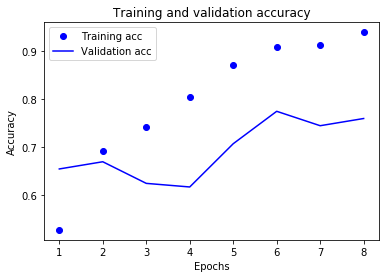

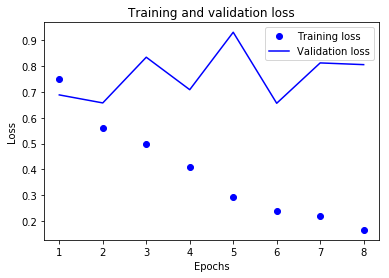

In [136]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

## Evaluation on test set

In [137]:
results = model.evaluate(X_test, y_test)

331/331 [==============================] - 1s 3ms/step


In [138]:
loss = results[0]
accuracy = results[1]

In [139]:
loss

0.8302505657391966

In [140]:
accuracy

0.7703927499650108

## Save the model and tokenizer

In [141]:
model.save("HospitalErrorDetectionMultiAttributeClassifier.h5")

In [142]:
with open('HospitalErrorDetectionMultiAttributeTokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=True)

## Run model on the entire dataset

In [143]:
model = load_model('HospitalErrorDetectionMultiAttributeClassifier.h5')

In [144]:
with open('HospitalErrorDetectionMultiAttributeTokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [145]:
def classifyTuples(model, tokenizer, value):
    value = [value]
    sequences = tokenizer.texts_to_sequences(value)
    testData = pad_sequences(sequences, maxlen=190)
    predictions = model.predict(testData)
    return int(predictions[0] >= 0.5)

In [146]:
ourLabels = []
for row in rows:
    label = classifyTuples(model, tokenizer, row)
    ourLabels.append(row + ',' + str(label))

In [147]:
len(ourLabels)

1652

In [148]:
with open('HospitalDatasetPredictions.pkl', 'wb') as f:
    pickle.dump(ourLabels, f)

In [158]:
ourLabels = np.asarray(ourLabels)
ourLabels = ourLabels[indices]

## Get only the faulty tuples

In [149]:
with open('HospitalDatasetPredictions.pkl', 'rb') as f:
    ourLabels = pickle.load(f)

In [150]:
errors = [row for row in ourLabels if row[-1] == '0']

In [151]:
len(errors)

748

In [152]:
with open('HospitalDatasetErrors.pkl', 'wb') as f:
    pickle.dump(errors, f)

### Convert pickle to dataframe

In [153]:
values = [row.split(',') for row in errors]

In [154]:
len(values)

748

In [155]:
headers = ['ProviderNumber', 'HospitalName', 'Address1', 'City', 'ZipCode','CountyName', 'PhoneNumber', 'HospitalOwner', 'Condition','Sample', 'label']

In [156]:
df = pd.DataFrame(values, columns=headers)

In [157]:
df.to_csv('HospitalErrors.csv',encoding='utf8',index=False)

## Metrics

In [159]:
from sklearn.metrics import classification_report

y_pred = []
for i in ourLabels:
    y_pred.append(int(i.split(',')[-1]))
print(classification_report(labels, y_pred))

             precision    recall  f1-score   support

          0       0.95      0.86      0.91       825
          1       0.88      0.96      0.92       827

avg / total       0.91      0.91      0.91      1652

